In [1]:
# Libraries
library(Seurat)
library(SeuratHelper)
library(dplyr)
library(stringr)
library(tidyr)
library(ggplot2)
library(readxl)
library(cowplot)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
devtools::load_all("~/projects/SeuratHelper")

ℹ Loading SeuratHelper


In [3]:
# Adjust PATH
wd <- getwd()
subdir <- "/bin"
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/vol/projects/odietric/covid19-bal-atlas-integration"

In [4]:
# Variables
in_file <- "data/BCB/seurat.Rds"
url_markers <- "https://syncandshare.desy.de/index.php/s/B4PDcHA8Jg8zZBm"
url_markers <- paste0(url_markers, "/download")
in_markers <- "docs/celltype/markers.xlsx"
plot_dir <- "analysis/BCB/dexa/"
dir.create(plot_dir)
out_file <- "data/BCB/dexa.Rds"

Warning message in dir.create(plot_dir):
“'analysis/BCB/dexa' already exists”


In [5]:
# Download data
download.file(url_markers, in_markers)

In [6]:
# Read data
sheets <- excel_sheets(in_markers)
markers <- list()
for (i in sheets) {
    markers[[i]] <- read_excel(in_markers, i)
}
ds <- readRDS(in_file)

New names:
• `` -> `...3`
• `` -> `...4`
New names:
• `` -> `...3`
New names:
• `` -> `...4`
• `` -> `...5`



dexa_core_down   dexa_core_up  dexa_response  down_deceased    up_deceased 
            58             23             30             75             36 

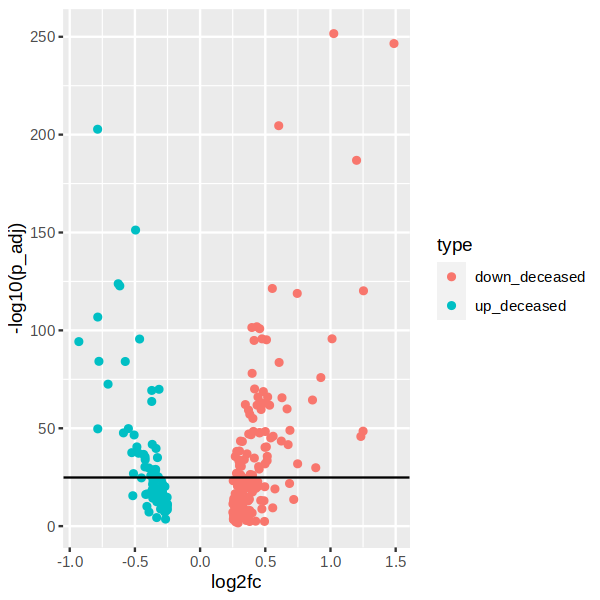

In [7]:
# Dexa response
dict <- markers$Dexa_revision
index <- dict$type %in% c("up_deceased", "down_deceased")
df <- dict[index, ]

# Plot
thresh <- 25
options(repr.plot.width=5, repr.plot.height=5)
ggplot(df, aes(log2fc, -log10(p_adj), col = type)) +
  geom_point() +
  geom_hline(yintercept = thresh)

# Subset gene list
dict <- rbind(dict[!index, ], dict[index & -log10(dict$p_adj) > thresh, ])
table(dict$type)

# Gene set overlap
gsets <- split(dict$gene, dict$type)

In [8]:
# Dexa - AUC
ds <- AddAUC(ds, gsets, "dexa.auc")

ERROR: Error in AddAUC(ds, gsets, "dexa.auc"): Assay dexa.auc  already exists. 
               To replace set force.recalc = TRUE


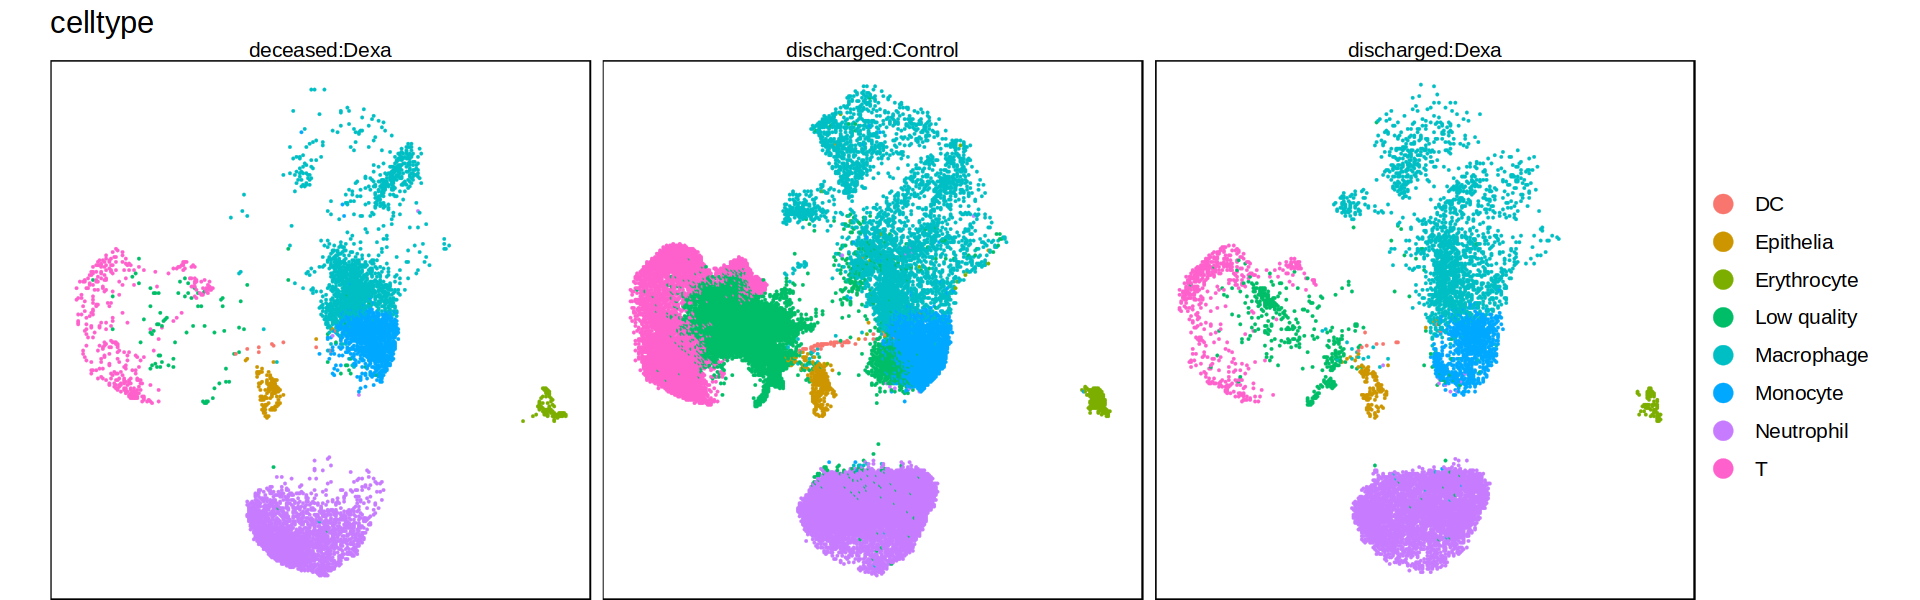

In [9]:
# Subset
cells <- colnames(ds)[which(ds$dexa_selection)]
dexa <- subset(ds, cells=cells)

# Combine categories
dexa$dexa_comparison <- paste0(dexa$outcome, ":", dexa$Dexa_group)

# Plot
options(repr.plot.width=16, repr.plot.height=5)
emb <- "mnn_30_umap"
plot_embedding(dexa, "celltype", split.by = "dexa_comparison", embedding=emb, legend.cols = 1, split.by.rows = 1)

Warning message in plot_embedding(dexa, split.by = "dexa_comparison", embedding = emb, :
“Expression/metadata for '' not found.”


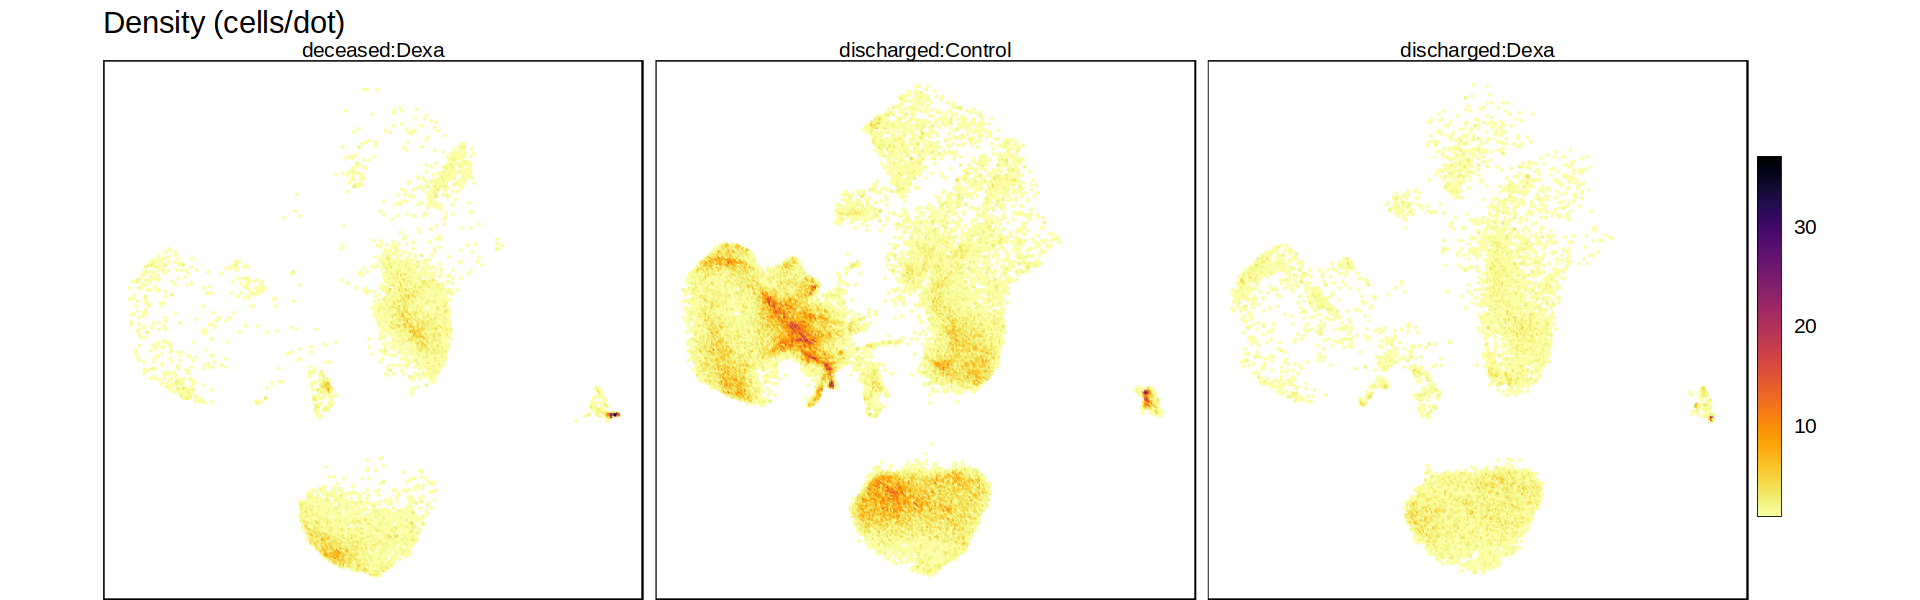

In [10]:
# Plot
options(repr.plot.width=16, repr.plot.height=5)
emb <- "mnn_30_umap"
plot_embedding(dexa, split.by = "dexa_comparison", embedding=emb, legend.cols = 1, split.by.rows = 1)

In [37]:
# Celltype specific differences between dexa groups
mat <- summarize_groups(dexa[["RNA"]]@data, dexa@meta.data[["lib_sample"]])
dim(mat)
mat[1, ]

Warning message in summarize_groups(dexa[["RNA"]]@data, dexa@meta.data[["lib_sample"]]):
“Groups are of type character and will be converted to factor.”


[1] 36601    11

L02:BAL_2    L05:BAL_5    L06:BAL_6    L07:BAL_7    L09:BAL_9   L14:BAL_17 
0.000000e+00 2.518482e-05 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 
  L19:BAL_22   L21:BAL_24   L30:BAL_33   L31:BAL_34   L32:BAL_35 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00

Warning message:
“Could not find dexa-response in the default search locations, found in dexa.auc assay instead”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


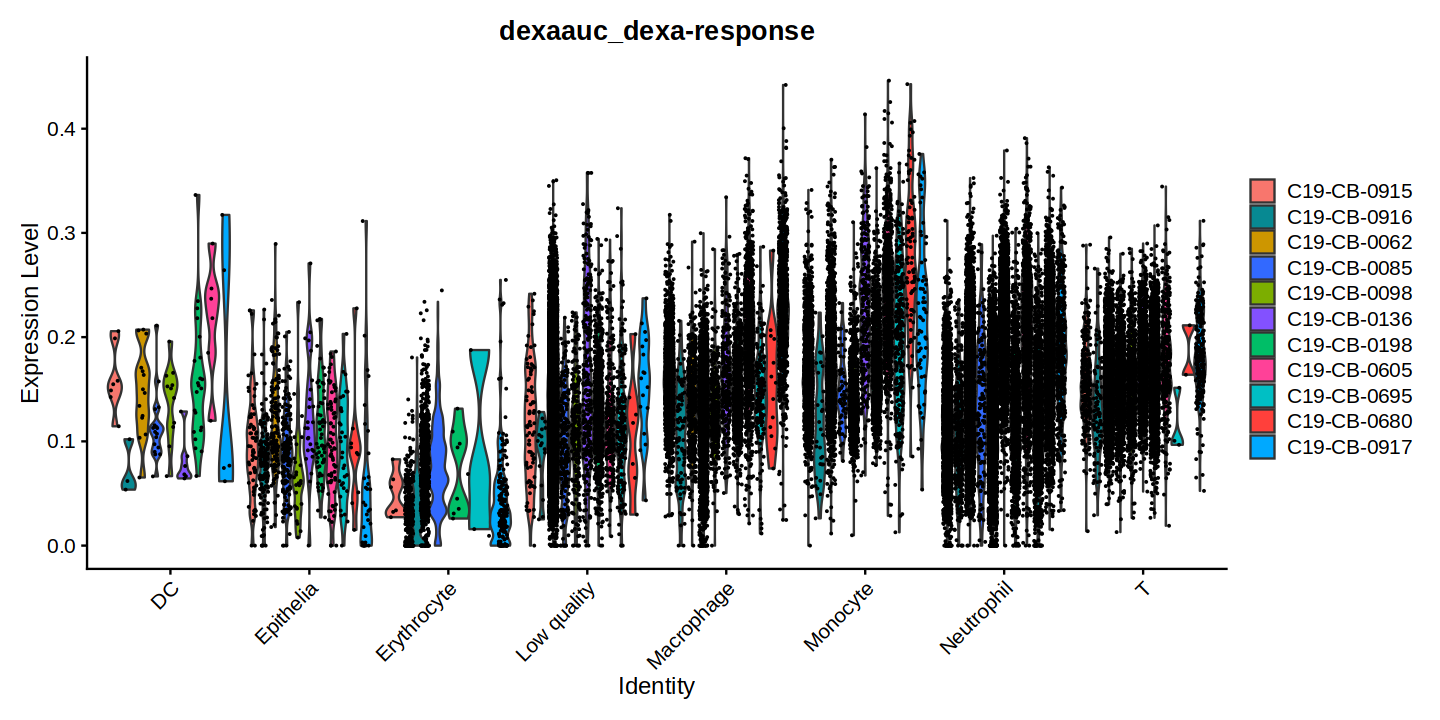

In [45]:
# Plot
options(repr.plot.width=12, repr.plot.height=6)
dexa$patient <- factor(dexa$patient, unique(dexa$patient[order(dexa$dexa_comparison)]))
p1 <- VlnPlot(dexa, "dexa-response", group.by="celltype", split.by = "patient", adjust = .5)

# Combine plots
plot_grid(p1)

In [ ]:

# Summarize
dat <- dex@meta.data[, c("patient", "dexa_comparison")]
dat$dexa_response <- dex@assays$dexa.auc@data["dexa-response", ]
dat <- summarize(group_by(dat, patient, dexa_comparison), dexa_response = mean(dexa_response))

x <- mean(dat$dexa_response[dat$dexa_comparison %in% c("deceased:Dexa", "discharged:Control")])
my_comparisons <- list(c("discharged:Dexa", "discharged:Control"), c("discharged:Dexa", "deceased:Dexa"))

# Plot
p2 <- ggplot(dat, aes(dexa_comparison, dexa_response, col = dexa_comparison)) +
geom_hline(yintercept = x, color="grey20") +
geom_boxplot(outlier.color=NA, width=.5) +
geom_point(shape = 21, size = 3, stroke=1, position="jitter") +
ggpubr::stat_compare_means(comparisons = my_comparisons, method = "t.test") +
scale_color_manual(values = c("indianred", "cyan3", "green3")) +
theme_classic(15) +
theme(
    axis.text.x = element_text(angle=45, hjust=1, vjust=1)
) +
labs(title = "Dexa response in BAL monocytes")

# Hypothesis test
wilcox.test(dat$dexa_response[dat$dexa_comparison == "discharged:Dexa"], 
       dat$dexa_response[dat$dexa_comparison %in% c("deceased:Dexa", "discharged:Control")],
       alternative = "greater"
      )

# Combine plots
plot_grid(p1, p2)

Warning message:
“Could not find dexa-response in the default search locations, found in dexa.auc assay instead”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


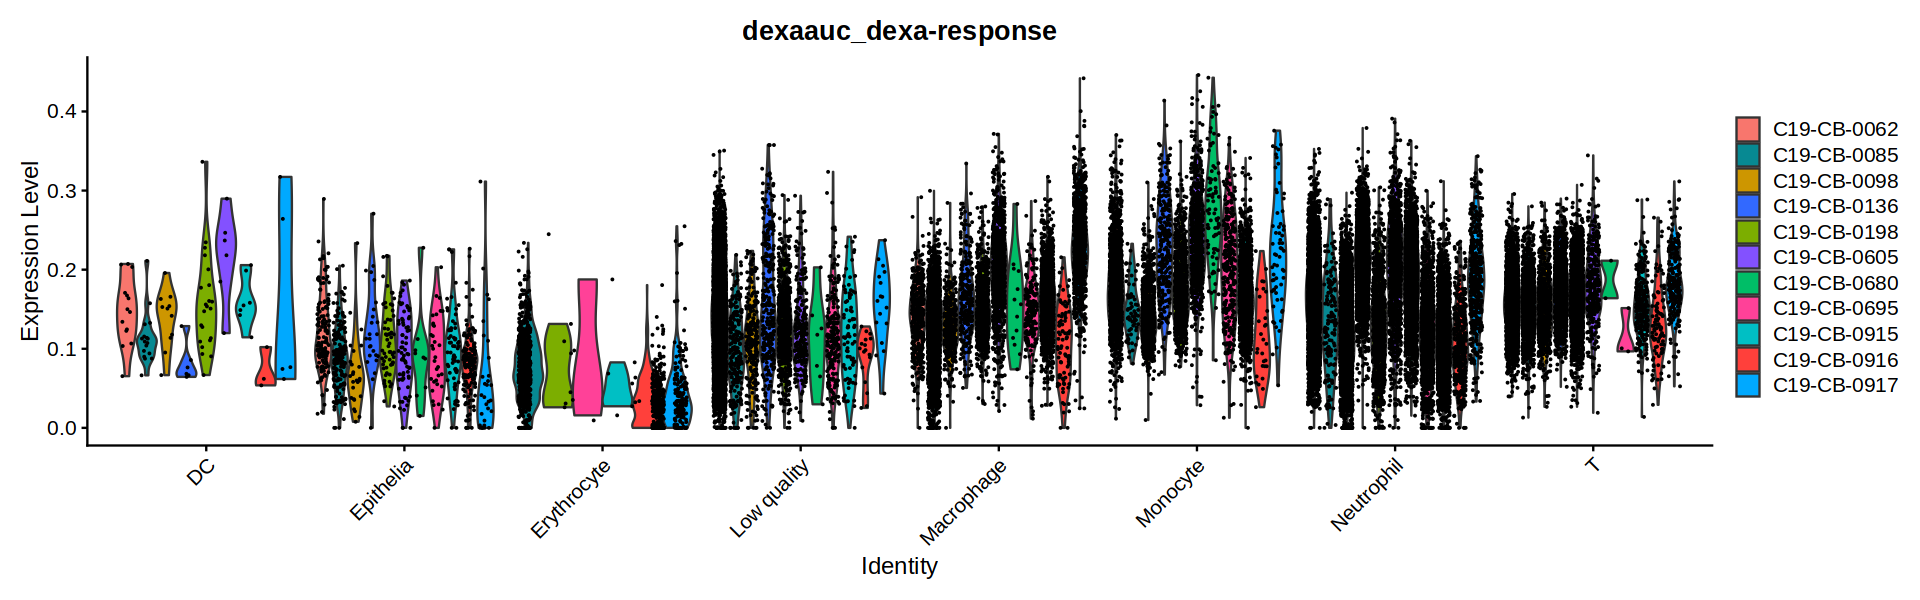

In [36]:
# Show enrichment of dexa response across celltypes
options(repr.plot.width=16, repr.plot.height=5)
VlnPlot(dexa, features = "dexa-response", group.by = "celltype", split.by="patient")

In [ ]:
# Subset
cells <- colnames(ds)[which(
    ds$dexa_selection &
    ds$celltype %in% c("Monocyte", "Macrophage")
)]
dexa <- subset(ds, cells=cells)

# Combine categories
dexa$Mp_type <- factor(dexa$celltype, c("Monocyte", "Macrophage"))
dexa$dexa_comparison <- paste0(dexa$outcome, ":", dexa$Dexa_group)

# Plot
options(repr.plot.width=16, repr.plot.height=5)
plot_embedding(dexa, "Mp_type", split.by = "dexa_comparison", embedding=emb, legend.cols = 1, split.by.rows = 1)

In [13]:
table(dexa$celltype)


         DC   Epithelia Erythrocyte Low quality  Macrophage    Monocyte 
         91         788        1247       15894        8438        6600 
 Neutrophil           T 
      21375        9386 

In [ ]:
dexa <- RunUMAP(dexa, dims=1:20, reduction="mnn", reduction.key = "UMAP_")

In [ ]:
# Plot
options(repr.plot.width=16, repr.plot.height=5)
emb <- "umap"
plot_embedding(dexa, "Mp_type", split.by = "dexa_comparison", embedding=emb, legend.cols = 1, split.by.rows = 1)

In [ ]:
# Plot
options(repr.plot.width=20, repr.plot.height=5)
plot_markers_embedding(dexa, assay = "dexa.auc", scale = FALSE, pt.size = .1, pt.stroke = .1, nrow = 1,
                       pl.title = "Dexa response", col.title = "AUC", embedding = emb)

In [ ]:
# Plot
options(repr.plot.width=20, repr.plot.height=10)
plot_markers_embedding(dexa, dict$gene[dict$type == "dexa_response"], pt.size = .1, pt.stroke = .1, nrow = 4,
                       pl.title = "Dexa response", embedding = emb)

In [ ]:
# Plot
options(repr.plot.width=15, repr.plot.height=5)
plot_embedding(dexa, "dexa-response", split.by = "dexa_comparison", embedding = emb, cells=cells)

Warning message in heatmap_expression(dexa, features = dict$gene, coldata = c("outcome", :
“The following features were not found in the assay: NAMPTP1, HLA-J, AC109326.1, NAPSB, CCL3L3, CCL3L3, ATP5G2 . Will be removed...”


[1] "Selecting color values from RColorBrewer..."


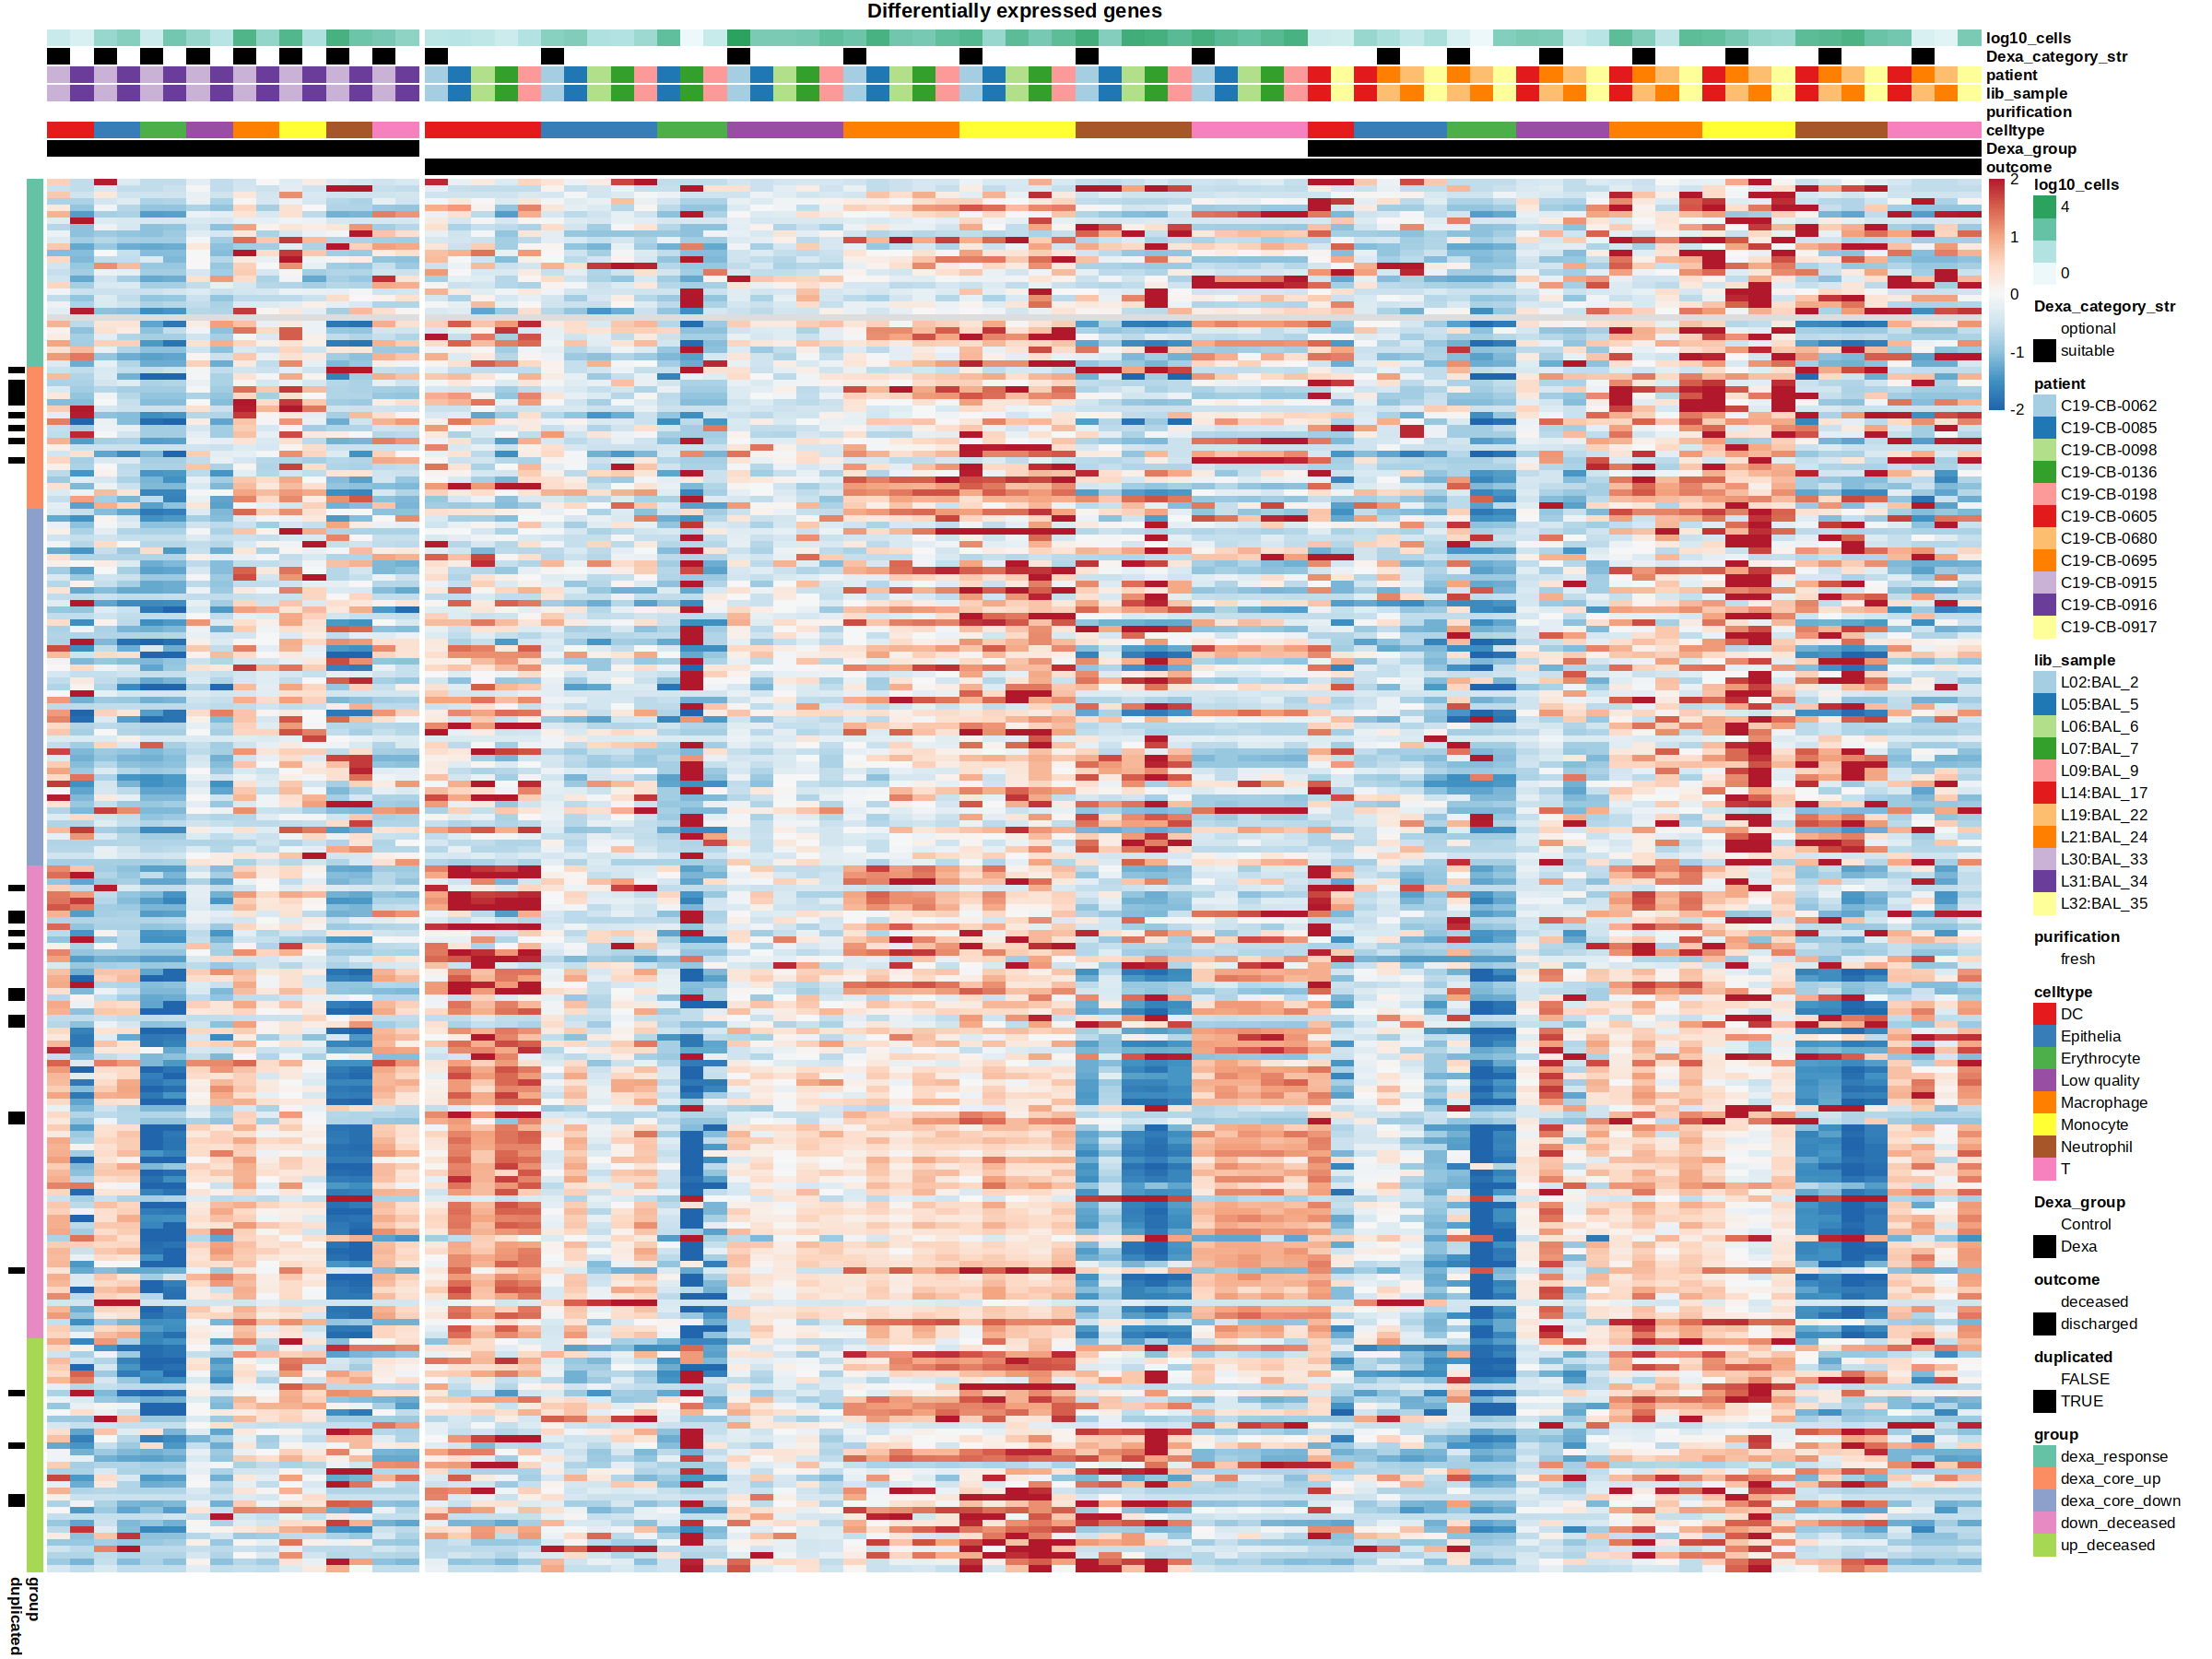

In [31]:
# Plot
options(repr.plot.width=20, repr.plot.height=15)
heatmap_expression(dexa, features = dict$gene, coldata = c("outcome", "Dexa_group", "celltype", "purification", 
                                    "lib_sample", "patient", "Dexa_category_str"), rowdata = dict$type)

In [ ]:
# Plot
options(repr.plot.width=10, repr.plot.height=15)
dict <- markers$Dexa_revision
de <- dict
ds$lib_sample_patient <- paste(ds$libname, ds$sample, ds$patient, sep=":")
cols <- list(
    "outcome"=c("deceased"="indianred", "discharged"="cyan3"),
    "Dexa_group"=c("Control"="grey", "Dexa"="green3"),
    "Mp_type"=c("Monocyte"="wheat", "Macrophage"="tan1")
)
p <- heatmap_expression(ds, features = de$gene, 
                        coldata = c("outcome", "Dexa_group", "Mp_type", "purification", 
                                    "lib_sample", "patient", "Dexa_category_str"), 
                        rowdata = de$type, cells=cells, annotation_colors = cols, 
                        title="Dexamethasone response in BAL macrophages in severe COVID-19")
p
fn <- paste0(plot_dir, "heatmap", "_", "dexa-macrophages", ".png")
ggsave(fn, p, width = 10, height=15)

In [ ]:
# Plot
options(repr.plot.width=10, repr.plot.height=10)
dict <- markers$Dexa_revision
de <- dict[dict$type == "dexa_response", ]
p <- heatmap_expression(ds, features = de$gene, 
                        coldata = c("outcome", "Dexa_group", "Mp_type", 
                                    "lib_sample", "patient", "Dexa_category_str"), 
                        cells=cells, annotation_colors = cols, show_rownames=T,
                        title="Dexamethasone response in BAL macrophages from severe COVID-19")
p
fn <- paste0(plot_dir, "heatmap", "_", "dexa-response-macrophages", ".png")
ggsave(fn, p, width = 10, height=10)

In [ ]:
# Plot
options(repr.plot.width=10, repr.plot.height=9)
p <- heatmap_expression(ds,assay = "dexa.auc", 
                        coldata = c("outcome", "Dexa_group", "Mp_type", 
                                    "lib_sample", "patient", "Dexa_category_str"), 
                        cells=cells, annotation_colors = cols, show_rownames=T, 
                        scale=F, heatmap_colors=viridis::magma(9), limits=c(0,1),
                        title="Dexamethasone response in BAL macrophages from severe COVID-19")
p
fn <- paste0(plot_dir, "heatmap", "_", "dexa-AUC-macrophages", ".png")
ggsave(fn, p, width = 10, height=9)

In [ ]:
# Plot
options(repr.plot.width=12, repr.plot.height=6)
cells <- colnames(ds)[which(
    ds$dexa_selection &
    ds$celltype %in% c("Monocyte")
)]
dex <- subset(ds, cells=cells)
dex$patient <- factor(dex$patient, unique(dex$patient[order(dex$dexa_comparison)]))
p1 <- VlnPlot(dex, "dexa-response", group.by="patient", split.by = "dexa_comparison", adjust = .5)

# Summarize
dat <- dex@meta.data[, c("patient", "dexa_comparison")]
dat$dexa_response <- dex@assays$dexa.auc@data["dexa-response", ]
dat <- summarize(group_by(dat, patient, dexa_comparison), dexa_response = mean(dexa_response))

x <- mean(dat$dexa_response[dat$dexa_comparison %in% c("deceased:Dexa", "discharged:Control")])
my_comparisons <- list(c("discharged:Dexa", "discharged:Control"), c("discharged:Dexa", "deceased:Dexa"))

# Plot
p2 <- ggplot(dat, aes(dexa_comparison, dexa_response, col = dexa_comparison)) +
geom_hline(yintercept = x, color="grey20") +
geom_boxplot(outlier.color=NA, width=.5) +
geom_point(shape = 21, size = 3, stroke=1, position="jitter") +
ggpubr::stat_compare_means(comparisons = my_comparisons, method = "t.test") +
scale_color_manual(values = c("indianred", "cyan3", "green3")) +
theme_classic(15) +
theme(
    axis.text.x = element_text(angle=45, hjust=1, vjust=1)
) +
labs(title = "Dexa response in BAL monocytes")

# Hypothesis test
wilcox.test(dat$dexa_response[dat$dexa_comparison == "discharged:Dexa"], 
       dat$dexa_response[dat$dexa_comparison %in% c("deceased:Dexa", "discharged:Control")],
       alternative = "greater"
      )

# Combine plots
plot_grid(p1, p2)

In [ ]:
# Plot
options(repr.plot.width=12, repr.plot.height=6)
cells <- colnames(ds)[which(
    ds$dexa_selection &
    ds$celltype %in% c("Macrophage")
)]
dex <- subset(ds, cells=cells)
dex$patient <- factor(dex$patient, unique(dex$patient[order(dex$dexa_comparison)]))
p1 <- VlnPlot(dex, "dexa-response", group.by="patient", split.by = "dexa_comparison", adjust = .5)

# Summarize
dat <- dex@meta.data[, c("patient", "dexa_comparison")]
dat$dexa_response <- dex@assays$dexa.auc@data["dexa-response", ]
dat <- summarize(group_by(dat, patient, dexa_comparison), dexa_response = mean(dexa_response))

x <- mean(dat$dexa_response[dat$dexa_comparison %in% c("deceased:Dexa", "discharged:Control")])
my_comparisons <- list(c("discharged:Dexa", "discharged:Control"), c("discharged:Dexa", "deceased:Dexa"))

# Plot
p2 <- ggplot(dat, aes(dexa_comparison, dexa_response, col = dexa_comparison)) +
geom_hline(yintercept = x, color="grey20") +
geom_boxplot(outlier.color=NA, width=.5) +
geom_point(shape = 21, size = 3, stroke=1, position="jitter") +
ggpubr::stat_compare_means(comparisons = my_comparisons, method = "t.test") +
scale_color_manual(values = c("indianred", "cyan3", "green3")) +
theme_classic(15) +
theme(
    axis.text.x = element_text(angle=45, hjust=1, vjust=1)
) +
labs(title = "Dexa response in BAL macrophages")

# Hypothesis test
wilcox.test(dat$dexa_response[dat$dexa_comparison == "discharged:Dexa"], 
       dat$dexa_response[dat$dexa_comparison %in% c("deceased:Dexa", "discharged:Control")],
       alternative = "greater"
      )

# Combine plots
plot_grid(p1, p2)

In [ ]:
# Statistic
c <- dex@meta.data[, c("patient", "dexa_comparison")]
x <- summarize_groups(dex@assays$dexa.auc@data, c$patient)["dexa-response", ]
c <- unique(c)
wilcox.test(x[c$dexa_comparison == "discharged:Dexa"], 
       x[c$dexa_comparison %in% c("discharged:Control")],
       alternative = "greater"
      )